In [128]:
%run "0. config.ipynb"

https://api.redmetrics.io/v1/event.csv?game=0fe53936-027f-461c-b087-b5b5737b2163&gameVersion=51b8a78a-8dd3-4a5e-9f41-01e6805e0f52&entityType=event
48516


# data preparation

In [109]:
players_stats = df_raw.loc[:, ["playerId"]]

players_stats = players_stats.set_index([ "playerId"] )

# intitialisation des colonnes
list_types = list(df_raw.type.unique())

for type_name in list_types:
  players_stats[type_name] = 0

# elle sent la connerie cette boucle...
for i, s in players_stats.iterrows():
#for i, s in players_stats[0:20].iterrows():
  for t in list_types:
    count = int(df_raw[ (df_raw.playerId == i) & (df_raw.type == t ) ].loc[:, ["type"] ].count())
    players_stats.loc[i, t] = count

#players_stats[players_stats.type.unique()] = 0
players_stats.head(10)

,start,selectmenu,reach,death,pickup,equip,craft,unequip,complete,switch,restart,gotourl,configure,gotomooc
playerId,,,,,,,,,,,,,,
9c183209-8867-46bb-9d29-9dda57e5a7bd,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9c183209-8867-46bb-9d29-9dda57e5a7bd,1,1,0,0,0,0,0,0,0,0,0,0,0,0
ab2d0f9a-13ec-4bc0-b5cd-58942d906954,1,1,0,0,0,0,0,0,0,0,0,0,0,0
ab2d0f9a-13ec-4bc0-b5cd-58942d906954,1,1,0,0,0,0,0,0,0,0,0,0,0,0
ecfe1f90-19c7-4ab9-8d6f-bd8feb7ff472,1,1,0,0,0,0,0,0,0,0,0,0,0,0
ecfe1f90-19c7-4ab9-8d6f-bd8feb7ff472,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5af5f837-2aa1-4d5e-86a3-05d39d6cf63d,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3607b3ec-9e2a-4043-9f07-8dbccee66cb3,0,1,8,6,3,3,1,1,1,0,0,0,0,0
3607b3ec-9e2a-4043-9f07-8dbccee66cb3,0,1,8,6,3,3,1,1,1,0,0,0,0,0


In [145]:
print players_stats.size
players_stats = players_stats.drop_duplicates()
print players_stats.size

1232
1232


In [146]:
players_stats.to_csv("data/players_stats.csv")

# PCA YOLO

In [113]:
from sklearn.decomposition import PCA

In [147]:
X = players_stats[ players_stats["complete"] > 0 ].as_matrix()

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

IndexError: index 1 is out of bounds for axis 1 with size 1

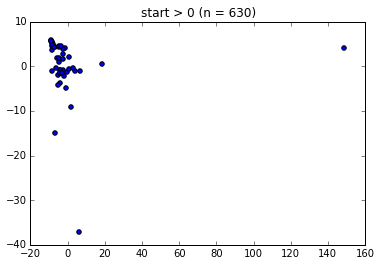

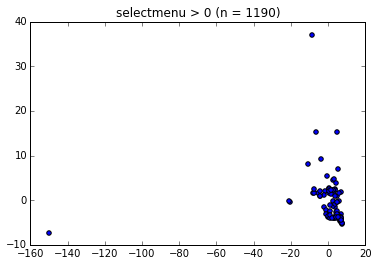

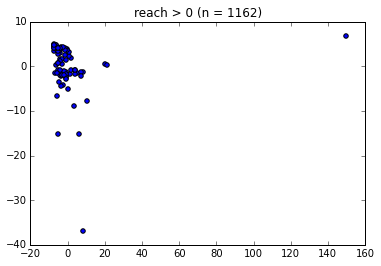

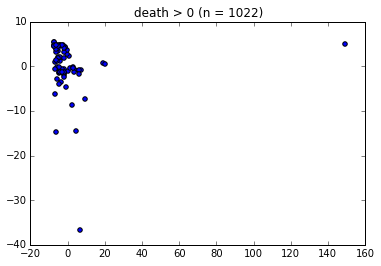

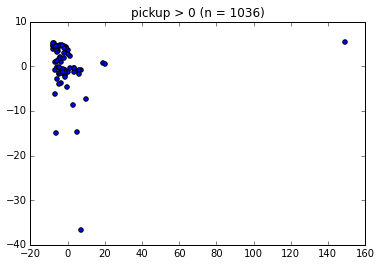

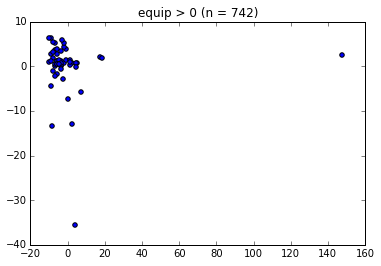

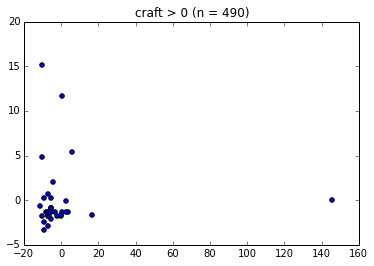

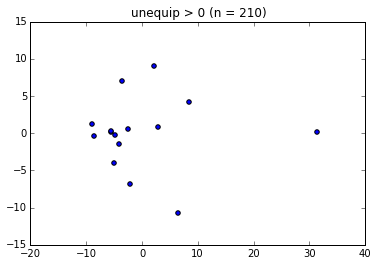

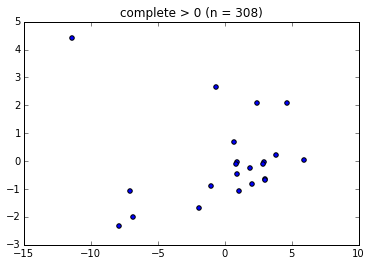

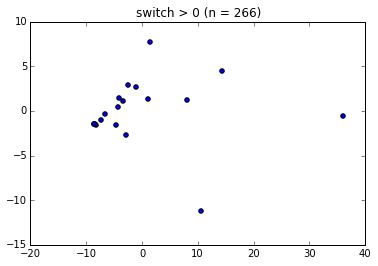

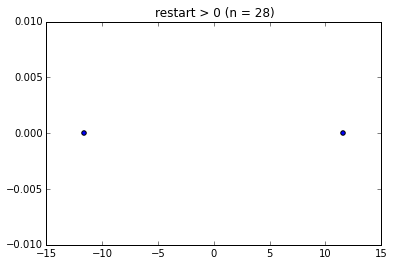

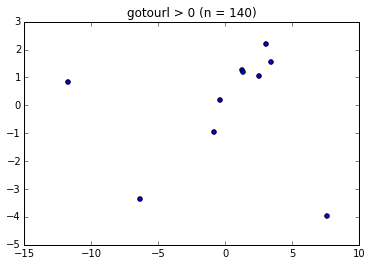

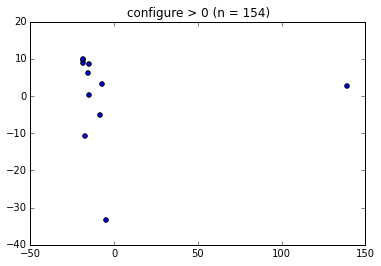

In [151]:
for title in list_types:
  X = players_stats[ players_stats[title] > 0 ].as_matrix()
  n = X.size
  
  # print n
  
  pca = PCA(n_components=2)
  X_r = pca.fit(X).transform(X)
  
  plt.figure()
  plt.scatter(X_r[:, 0], X_r[:, 1]) #, c=c, label=target_name)
  plt.title("%s > 0 (n = %s)" % (title, n))
  plt.legend()

plt.show()